In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
import numpy as np
from scipy.signal import savgol_filter

In [2]:
file_path = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-2025-07-07-16-47-35.tsv"
df = pd.read_csv(file_path, sep="\t", skiprows=5)

In [3]:
df.columns = [col.strip().lstrip('#').strip() for col in df.columns]

In [4]:
df[df.columns[0]] = pd.to_numeric(df[df.columns[0]], errors="coerce")
df[df.columns[1]] = pd.to_numeric(df[df.columns[1]], errors="coerce")
df[df.columns[1]] = df[df.columns[1]] * 1000  # 將 flux 單位轉成 mJy
df = df.dropna()

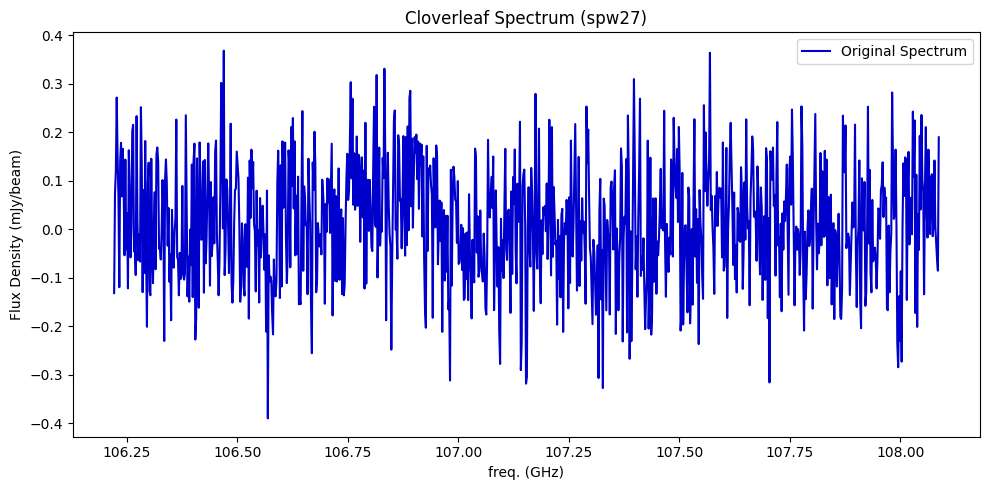

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df[df.columns[0]], df[df.columns[1]], label="Original Spectrum", color="mediumblue")
plt.xlabel("freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Cloverleaf Spectrum (spw27)")
plt.grid(False)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
#加入譜線(沒存到HAHA)
#line_file = "member.uid___A001_X2d20_X39ab.Cloverleaf_sci.spw27.cube.I.pbcor.fits-Z-profile-Region_3-Statistic_Mean-Coordinate_Current-2025-07-07-16-47-35.tsv.tsv"
#df_lines = pd.read_csv(file_path, sep="\t", skiprows=5)
#df_lines.columns = [col.strip().lstrip('#').strip() for col in df_lines.columns]
#line_positions = pd.to_numeric(df_lines[df_lines.columns[0]], errors="coerce").dropna()

#換成手打   (freq, label)
my_lines = [(106.857,"H2O")]

### binning

In [7]:
x_raw = df[df.columns[0]].values
y_raw = df[df.columns[1]].values

# binning
def rebin_spectrum(x, y, bin_size):
    n_bins = len(y) // bin_size
    x = x[:n_bins * bin_size]
    y = y[:n_bins * bin_size]
    x_binned = x.reshape(n_bins, bin_size).mean(axis=1)
    y_binned = y.reshape(n_bins, bin_size).mean(axis=1)
    return x_binned, y_binned

x_bin, y_bin = rebin_spectrum(x_raw, y_raw, bin_size=2)

### boxcar smoothing

In [18]:
# boxcar smoothing
def boxcar_smooth(y, kernel_size):
    kernel = np.ones(kernel_size) / kernel_size
    return np.convolve(y, kernel, mode='same')

y_smooth = boxcar_smooth(y_bin, kernel_size=8)

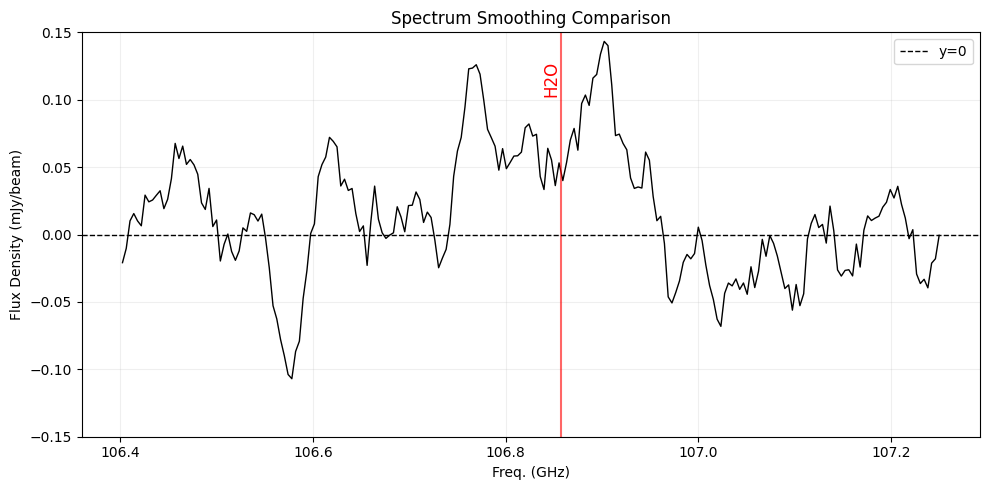

In [21]:
mask = (x_bin >= 106.4) & (x_bin <= 107.25)
x_limited = x_bin[mask]
y_limited = y_smooth[mask]


plt.figure(figsize=(10, 5))
plt.plot(x_limited, y_limited, color="black", linewidth=1)

for freq, label in my_lines:
    plt.axvline(freq, color="red", linestyle="-", alpha=0.6)
    plt.text(freq, max(y_limited)*0.9, label, rotation=90, color="red", fontsize=12, ha='right', va='top')
plt.axhline(0, color="black", linewidth=1, linestyle="--", label="y=0")


plt.xlabel("Freq. (GHz)")
plt.ylabel("Flux Density (mJy/beam)")
plt.title("Spectrum Smoothing Comparison")
plt.ylim(-0.15, 0.15)
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()